<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

# Worksheet 5.2: DGA Detection - Answers
This worksheet covers concepts covered in the second part of Module 5 - Supervised Learning.  It should take no more than 40-60 minutes to complete.  Please raise your hand if you get stuck.  

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* Scikit-learn (http://scikit-learn.org/stable/documentation.html)
* YellowBrick (http://www.scikit-yb.org/en/latest/)
* Seaborn (https://seaborn.pydata.org)
* Lime (https://github.com/marcotcr/lime)

In [1]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt
import matplotlib
import lime
import io
import pickle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Worksheet - Answer - DGA Detection using Machine Learning

This worksheet is a step-by-step guide on how to detect domains that were generated using "Domain Generation Algorithm" (DGA). We will walk you through the process of transforming raw domain strings to Machine Learning features and creating a decision tree classifer which you will use to determine whether a given domain is legit or not. Once you have implemented the classifier, the worksheet will walk you through evaluating your model.  

Overview 2 main steps:

1. **Feature Engineering** - from raw domain strings to numeric Machine Learning features using DataFrame manipulations
2. **Machine Learning Classification** - predict whether a domain is legit or not using a Decision Tree Classifier


  

**DGA - Background**

"Various families of malware use domain generation
algorithms (DGAs) to generate a large number of pseudo-random
domain names to connect to a command and control (C2) server.
In order to block DGA C2 traffic, security organizations must
first discover the algorithm by reverse engineering malware
samples, then generate a list of domains for a given seed. The
domains are then either preregistered, sink-holed or published
in a DNS blacklist. This process is not only tedious, but can
be readily circumvented by malware authors. An alternative
approach to stop malware from using DGAs is to intercept DNS
queries on a network and predict whether domains are DGA
generated. Much of the previous work in DGA detection is based
on finding groupings of like domains and using their statistical
properties to determine if they are DGA generated. However,
these techniques are run over large time windows and cannot be
used for real-time detection and prevention. In addition, many of
these techniques also use contextual information such as passive
DNS and aggregations of all NXDomains throughout a network.
Such requirements are not only costly to integrate, they may not
be possible due to real-world constraints of many systems (such
as endpoint detection). An alternative to these systems is a much
harder problem: detect DGA generation on a per domain basis
with no information except for the domain name. Previous work
to solve this harder problem exhibits poor performance and many
of these systems rely heavily on manual creation of features;
a time consuming process that can easily be circumvented by
malware authors..."    
[Citation: Woodbridge et. al 2016: "Predicting Domain Generation Algorithms with Long Short-Term Memory Networks"]

A better alternative for real-world deployment would be to use "featureless deep learning" - We have a separate notebook where you can see how this can be implemented!

**However, let's learn the basics first!!!**


## Worksheet for Part 2 - Feature Engineering

#### Breakpoint: Load Features and Labels

If you got stuck in Part 1, please simply load the feature matrix we prepared for you, so you can move on to Part 2 and train a Decision Tree Classifier.

In [2]:
df_final = pd.read_csv('../data/dga_features_final_df.csv')
#If you didn't get a working dataset, uncomment this line
#df_final = pd.read_csv('../data/our_data_dga_features_final_df.csv')

print(df_final.isDGA.value_counts())
df_final.head()

1    1000
0    1000
Name: isDGA, dtype: int64


isDGA  length  digits   entropy  vowel-cons  firstDigitIndex       ngrams
0      1      13       0  3.546594    0.083333                0   744.670940
1      1      26      10  4.132944    0.333333                1   715.217265
2      1       8       0  2.500000    0.333333                0  1918.797619
3      1      26       7  4.180833    0.357143                1   682.269402
4      1      24       9  3.834963    0.666667                2   544.178140

In [3]:
# Load dictionary of common english words from part 1
from six.moves import cPickle as pickle
with open('../data/d_common_en_words' + '.pickle', 'rb') as f:
        d = pickle.load(f)

## Part 2 - Machine Learning

To learn simple classification procedures using [sklearn](http://scikit-learn.org/stable/) we have split the work flow into 5 steps.

### Step 1: Prepare Feature matrix and ```target``` vector containing the URL labels

- In statistics, the feature matrix is often referred to as ```X```
- target is a vector containing the labels for each URL (often also called *y* in statistics)
- In sklearn both the input and target can either be a pandas DataFrame/Series or numpy array/vector respectively (can't be lists!)

Tasks:
- assign 'isDGA' column to a pandas Series named 'target'
- drop 'isDGA' column from ```dga``` DataFrame and name the resulting pandas DataFrame 'feature_matrix'

In [4]:
target = df_final['isDGA']
feature_matrix = df_final.drop(['isDGA'], axis=1)
print('Final features', feature_matrix.columns)

feature_matrix.head()

Final features Index(['length', 'digits', 'entropy', 'vowel-cons', 'firstDigitIndex',
       'ngrams'],
      dtype='object')


length  digits   entropy  vowel-cons  firstDigitIndex       ngrams
0      13       0  3.546594    0.083333                0   744.670940
1      26      10  4.132944    0.333333                1   715.217265
2       8       0  2.500000    0.333333                0  1918.797619
3      26       7  4.180833    0.357143                1   682.269402
4      24       9  3.834963    0.666667                2   544.178140

### Step 2: Simple Cross-Validation

Tasks:
- split your feature matrix X and target vector into train and test subsets using sklearn [model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [5]:
# Simple Cross-Validation: Split the data set into training and test data
feature_matrix_train, feature_matrix_test, target_train, target_test = model_selection.train_test_split(feature_matrix, target, test_size=0.25, random_state=33)

In [6]:
feature_matrix_train.count()

length             1500
digits             1500
entropy            1500
vowel-cons         1500
firstDigitIndex    1500
ngrams             1500
dtype: int64

In [7]:
feature_matrix_test.count()

length             500
digits             500
entropy            500
vowel-cons         500
firstDigitIndex    500
ngrams             500
dtype: int64

In [8]:
target_train.sample(5)

336     1
1390    0
1953    0
793     1
534     1
Name: isDGA, dtype: int64

In [9]:
target_train.value_counts()

1    756
0    744
Name: isDGA, dtype: int64

### Step 3: Train the model and make a prediction

Finally, we have prepared and segmented the data. Let's start classifying!!   

Tasks:

-  Use the sklearn [tree.DecisionTreeClassfier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), create a decision tree with standard parameters, and train it using the ```.fit()``` function with ```X_train``` and ```target_train``` data.
-  Next, pull a few random rows from the data and see if your classifier got it correct.

If you are interested in trying a real unknown domain, you'll have to create a function to generate the features for that domain before you run it through the classifier (see function ```is_dga``` a few cells below). 

In [10]:
# Train the decision tree based on the entropy criterion
clf = tree.DecisionTreeClassifier()  # clf means classifier
clf = clf.fit(feature_matrix_train, target_train)

# Extract a row from the test data
test_feature = feature_matrix_test[185:186]
test_target = target_test[185:186]

# Make the prediction
pred = clf.predict(test_feature)
print('Predicted class:', pred)
print('Accurate prediction?', pred[0] == test_target)

Predicted class: [0]
Accurate prediction? 1421    True
Name: isDGA, dtype: bool


In [11]:
pred[0] == test_target

1421    True
Name: isDGA, dtype: bool

### Making a Prediction
The code below demonstrates how you will go from an unknown raw domain to predicting whether it is DGA or not.  The key thing is that you have to regenerate all the features, and create a 1 row dataframe of all your features which is then passed to the model. 

In [12]:
# For simplicity let's just copy the needed function in here again

def H_entropy (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [13]:
def is_dga(domain, clf, d):
    # Function that takes new domain string, trained model 'clf' as input and
    # dictionary d of most common english words
    # returns prediction
    
    domain_features = np.empty([1,6])
    # order of features is ['length', 'digits', 'entropy', 'vowel-cons', firstDigitIndex, 'ngrams']
    domain_features[0,0] = len(domain)
    pattern = re.compile('([0-9])')
    domain_features[0,1] = len(re.findall(pattern, domain))
    domain_features[0,2] = H_entropy(domain)
    domain_features[0,3] = vowel_consonant_ratio(domain)
    domain_features[0,4] = firstDigitIndex(domain)
    domain_features[0,5] = average_ngram_feature([ngram_feature(domain, d, 1), 
                                                  ngram_feature(domain, d, 2), 
                                                  ngram_feature(domain, d, 3)])
    
    pred = clf.predict(domain_features)
    return pred[0]


print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('spardeingeld'), is_dga('spardeingeld', clf, d))  
print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('google'), is_dga('google', clf, d)) 
print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('1vxznov16031kjxneqjk1rtofi6'), is_dga('1vxznov16031kjxneqjk1rtofi6', clf, d)) 
print('Predictions of domain %s is [0 means legit and 1 dga]: ' %('lthmqglxwmrwex'), is_dga('lthmqglxwmrwex', clf, d)) 


Predictions of domain spardeingeld is [0 means legit and 1 dga]:  0
Predictions of domain google is [0 means legit and 1 dga]:  0
Predictions of domain 1vxznov16031kjxneqjk1rtofi6 is [0 means legit and 1 dga]:  1
Predictions of domain lthmqglxwmrwex is [0 means legit and 1 dga]:  1


In [14]:
is_dga('adfajdskflajlkdsfjaksdjf;lakjsdfkajdsf8989dsf32.com', clf, d)

1

### Step 4: Assess model accuracy with simple cross-validation

Tasks:
- Make predictions for all your data. Call the ```.predict()``` method on the clf with your training data ```X_train``` and store the results in a variable called ```target_pred```.
- Use sklearn [metrics.accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to determine your models accuracy. Detailed Instruction:
    - Use your trained model to predict the labels of your test data ```X_test```. Run ```.predict()``` method on the clf with your test data ```X_test``` and store the results in a variable called ```target_pred```.. 
    - Then calculate the accuracy using ```target_test``` (which are the true labels/groundtruth) AND your models predictions on the test portion ```target_pred``` as inputs. The advantage here is to see how your model performs on new data it has not been seen during the training phase. The fair approach here is a simple **cross-validation**!
    
- Print out the confusion matrix using [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- Use Yellowbrick to visualize the classification report and confusion matrix. (http://www.scikit-yb.org/en/latest/examples/modelselect.html#common-metrics-for-evaluating-classifiers)

In [15]:
# fair approach: make prediction on test data portion
target_pred = clf.predict(feature_matrix_test)
print(metrics.accuracy_score(target_test, target_pred))
print('Confusion Matrix\n', metrics.confusion_matrix(target_test, target_pred))

0.88
Confusion Matrix
 [[217  39]
 [ 21 223]]


In [16]:
# Classification Report...neat summary
print(metrics.classification_report(target_test, target_pred, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.91      0.85      0.88       256
         dga       0.85      0.91      0.88       244

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



In [17]:
# short-cut
clf.score(feature_matrix_test, target_test)

0.88

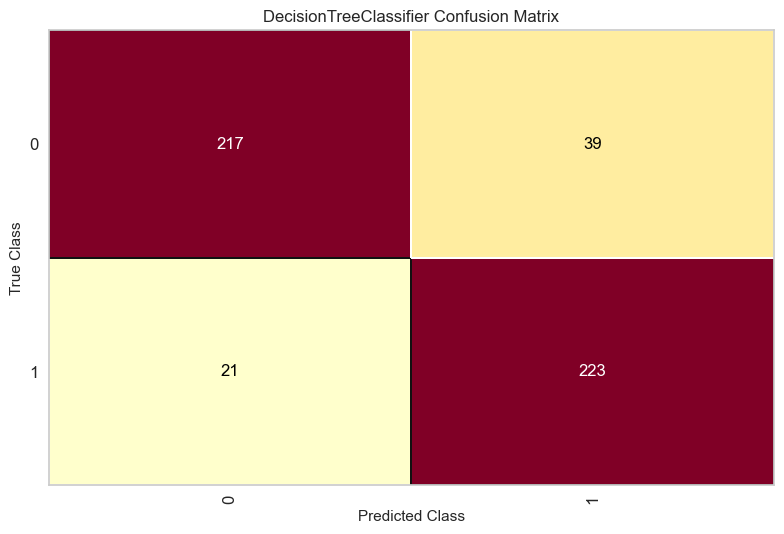

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
viz = ConfusionMatrix(clf)
viz.fit(feature_matrix_train, target_train)
viz.score(feature_matrix_test, target_test)
viz.show()

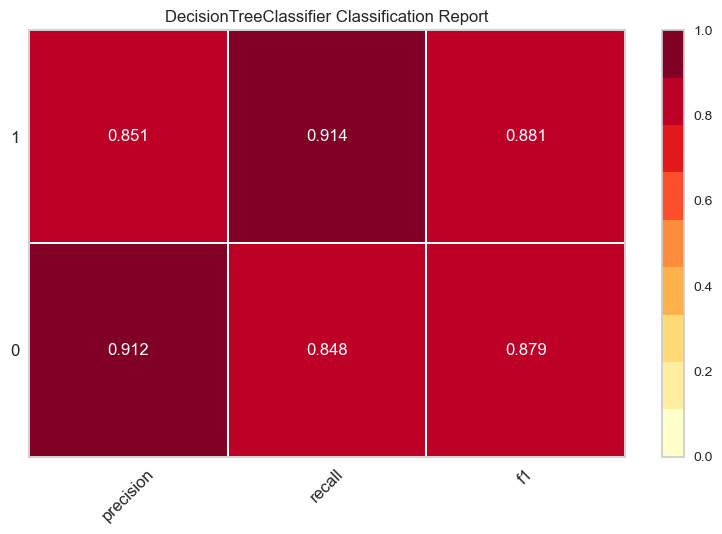

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [19]:
viz = ClassificationReport(clf)
viz.fit(feature_matrix_train, target_train)
viz.score(feature_matrix_test, target_test)
viz.show()

### Step 5: Assess model accuracy with k-fold cross-validation

Tasks:
- Partition the dataset into *k* different subsets
- Create *k* different models by training on *k-1* subsets and testing on the remaining subsets
- Measure the performance on each of the models and take the average measure.

*Short-Cut*
All of these steps can be easily achieved by simply using sklearn's [model_selection.KFold()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and [model_selection.cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) functions.

In [20]:
cvKFold = model_selection.KFold(n_splits=3, shuffle=True, random_state=33) 
cvKFold.get_n_splits(feature_matrix)

3

In [21]:
scores = model_selection.cross_val_score(clf, feature_matrix, target, cv=cvKFold)
print(scores)

[0.88005997 0.87706147 0.86786787]


In [22]:
# Get avergage score +- Standard Error (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html)
from scipy.stats import sem
def mean_score( scores ):
    return "Mean score: {0:.3f} (+/- {1:.3f})".format( np.mean(scores), sem( scores ))
print( mean_score( scores))

Mean score: 0.875 (+/- 0.004)


#### (Optional) Visualizing your Tree
As an optional step, you can actually visualize your tree.  The following code will generate a graph of your decision tree.  You will need graphviz (http://www.graphviz.org) and pydotplus (or pydot) installed for this to work.
The Griffon VM has this installed already, but if you try this on a Mac, or Linux machine you will need to install graphviz.

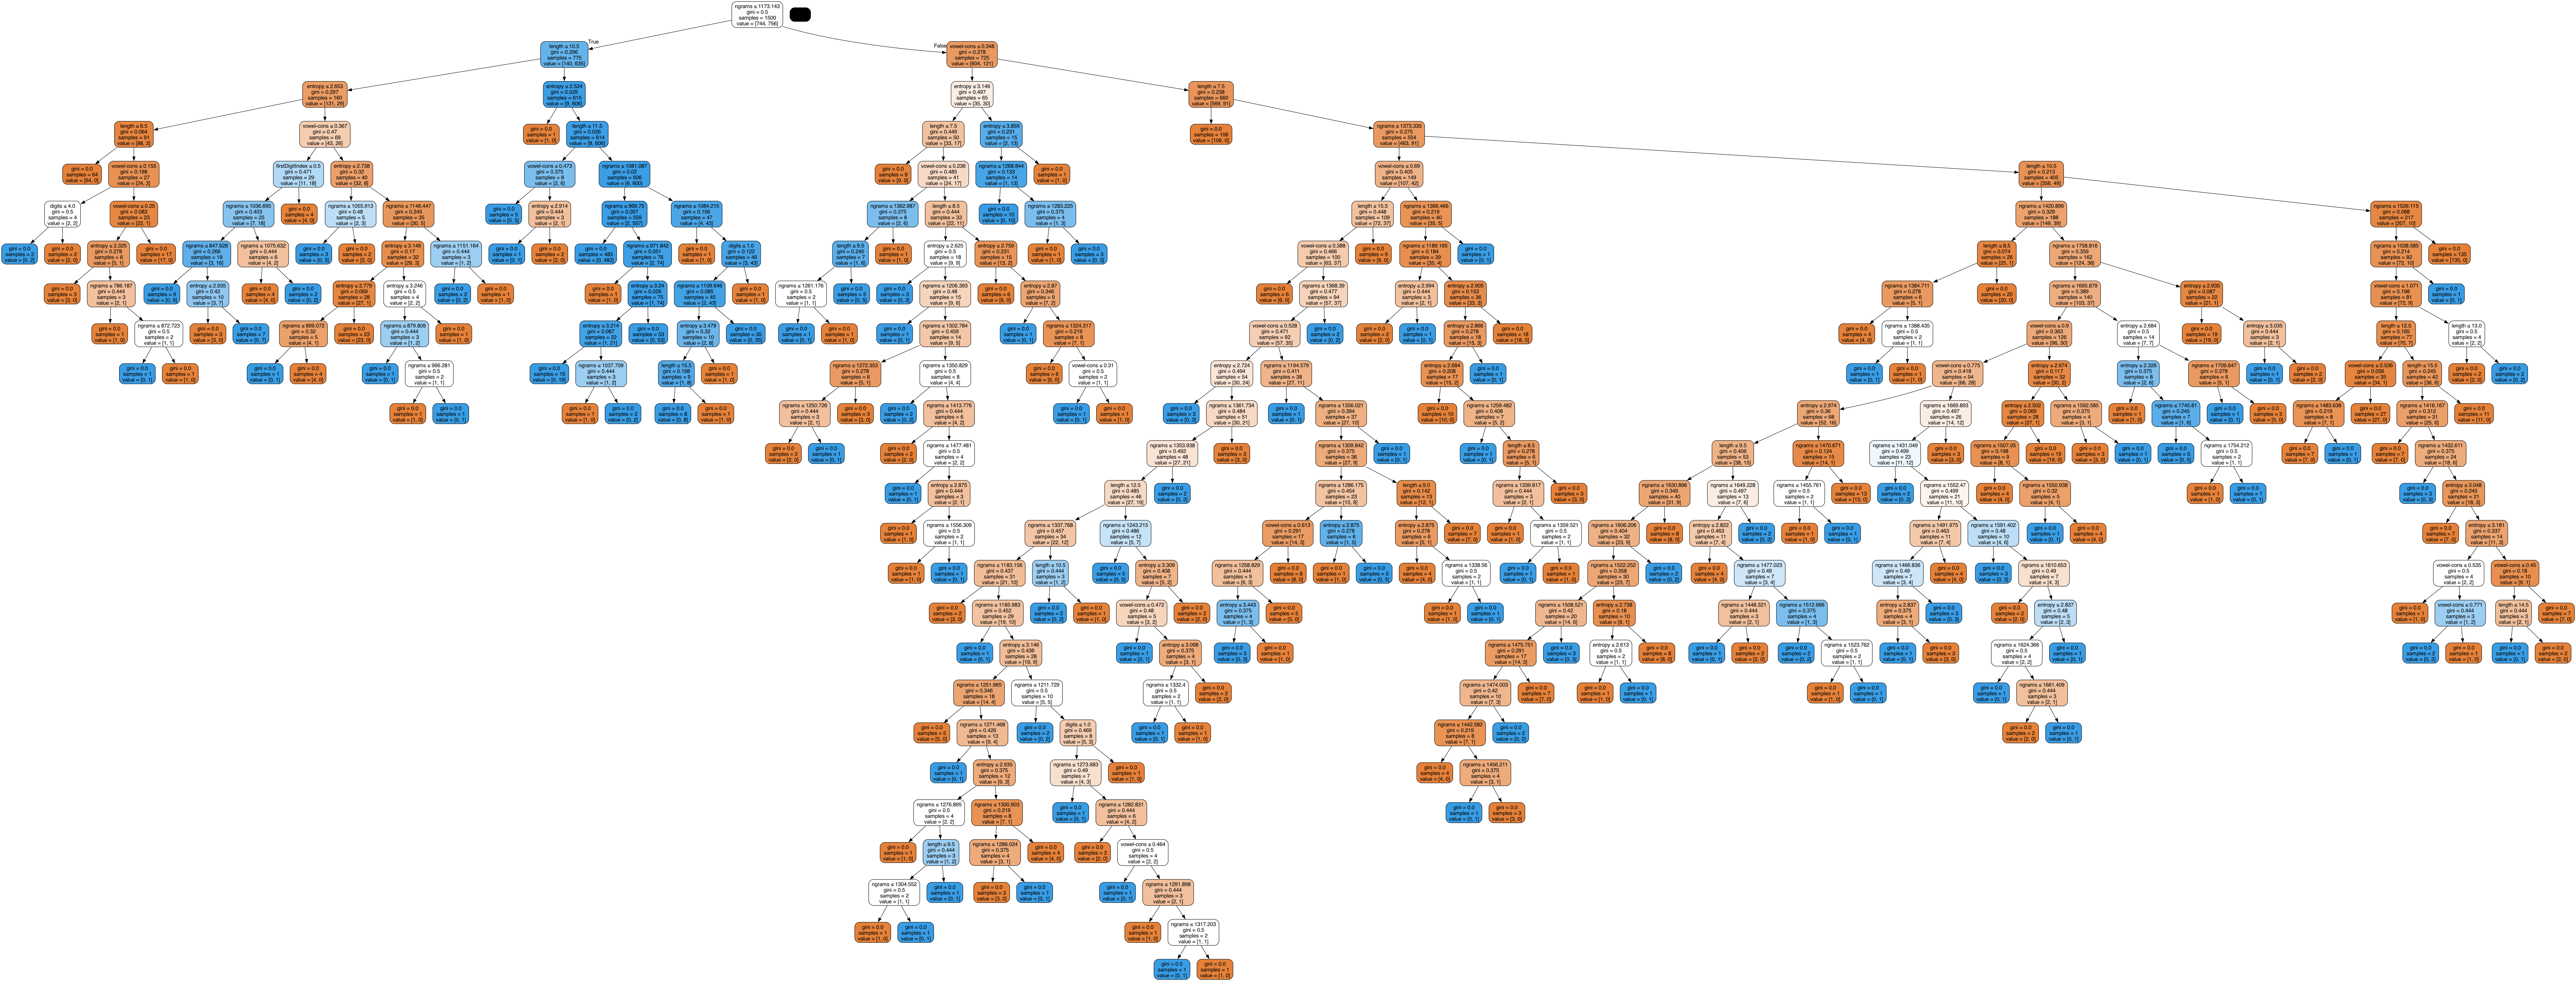

In [25]:
# These libraries are used to visualize the decision tree and require that you have GraphViz
# and pydot or pydotplus installed on your computer.

from IPython.core.display import Image
import pydotplus as pydot


dot_data = io.StringIO() 
tree.export_graphviz(clf, out_file=dot_data, 
                     feature_names=['length', 'digits', 'entropy', 'vowel-cons', 'firstDigitIndex','ngrams'],
                    filled=True, rounded=True,  
                    special_characters=True) 

graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())


## Other Models
Now that you've built a Decision Tree, let's try out two other classifiers and see how they perform on this data.  For this next exercise, create classifiers using:

* Support Vector Machine
* Random Forest
* K-Nearest Neighbors (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)  

Once you've done that, run the various performance metrics to determine which classifier works best.

In [26]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [27]:
#Create the Random Forest Classifier
random_forest_clf = RandomForestClassifier(n_estimators=10, 
                             max_depth=None, 
                             min_samples_split=2, 
                             random_state=0)

random_forest_clf = random_forest_clf.fit(feature_matrix_train, target_train)

In [28]:
random_forest_predictions = random_forest_clf.predict(feature_matrix_test)

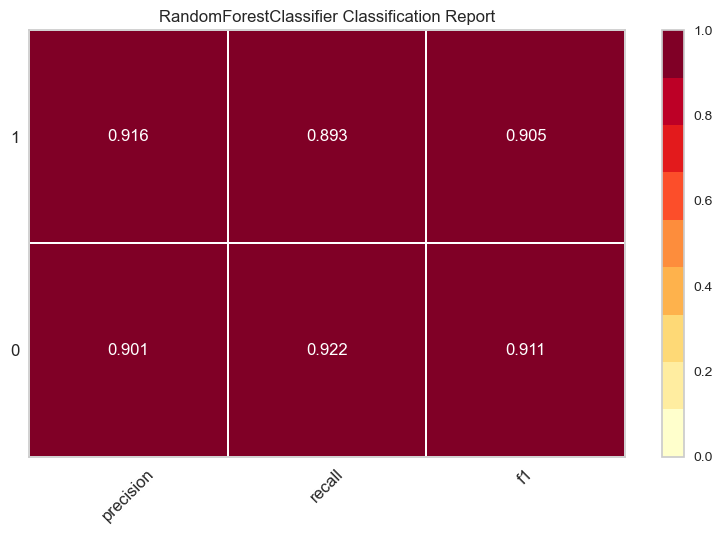

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [29]:
viz = ClassificationReport(random_forest_clf)
viz.fit(feature_matrix_train, target_train)
viz.score(feature_matrix_test, target_test)
viz.poof()

In [30]:
metrics.accuracy_score(target_test, random_forest_predictions)

0.908

In [31]:
#Next, create the SVM classifier
svm_classifier = svm.SVC()
svm_classifier = svm_classifier.fit(feature_matrix_train, target_train)  

In [32]:
svm_preds = svm_classifier.predict(feature_matrix_test)

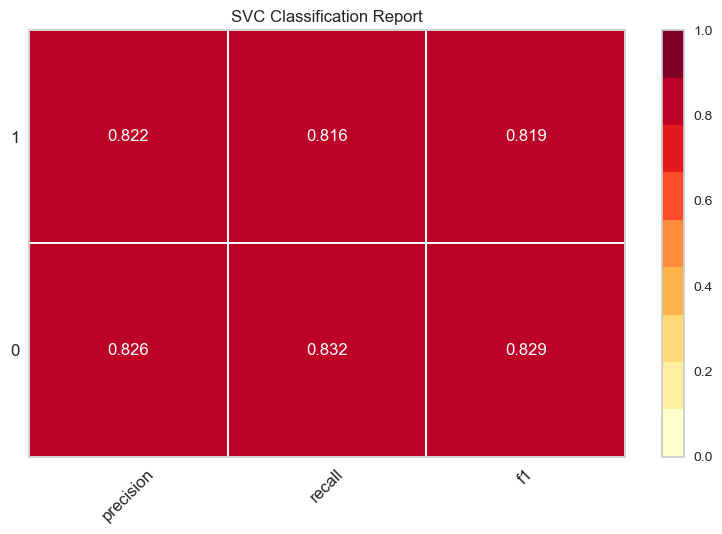

<Axes: title={'center': 'SVC Classification Report'}>

In [33]:
viz = ClassificationReport(svm_classifier)
viz.fit(feature_matrix_train, target_train)
viz.score(feature_matrix_test, target_test)
viz.poof()

In [34]:
#Finally the knn
knn_clf = KNeighborsClassifier()
knn_clf = knn_clf.fit(feature_matrix_train, target_train) 

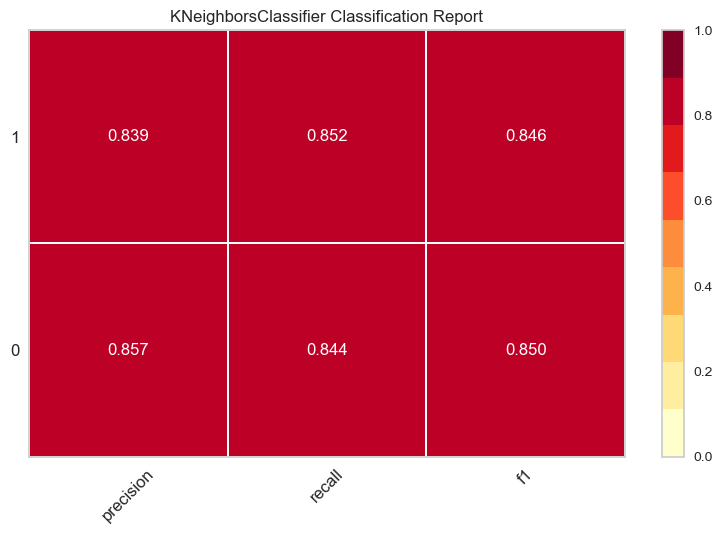

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [35]:
viz = ClassificationReport(knn_clf)
viz.fit(feature_matrix_train, target_train)
viz.score(feature_matrix_test, target_test)
viz.poof()

## Explain a Prediction
In the example below, you can use LIME to explain how a classifier arrived at its prediction.  Try running LIME with the various classifiers you've created and various rows to see how it functions. 

In [36]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(feature_matrix_train, 
                                                   feature_names=['length', 'digits', 'entropy', 'vowel-cons', 'firstDigitIndex','ngrams'], 
                                                   class_names=['legit', 'isDGA'], 
                                                   discretize_continuous=False)

In [37]:
exp = explainer.explain_instance(feature_matrix_test.iloc[12], 
                                 random_forest_clf.predict_proba, 
                                 num_features=6)

In [38]:
exp.show_in_notebook(show_table=True, show_all=True)

In [39]:
feature_matrix_test.iloc[8]

length               12.000000
digits                0.000000
entropy               3.022055
vowel-cons            0.090909
firstDigitIndex       0.000000
ngrams             1187.669192
Name: 361, dtype: float64

In [40]:
# Save the Decision Tree for Worksheet 11
filename = '../data/dga_decision_tree.sav'
pickle.dump(clf, open(filename, 'wb'))